In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [15]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [16]:
len(words)


32033

In [17]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [41]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [49]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngains = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)
# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [56]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = bngain *((hpreact - hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True)) + bnbias #
  # need to revist batch normalization
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

(array([138., 192., 182., 189., 168., 158., 160., 140., 149., 132., 108.,
        142., 100., 109., 112., 123., 108., 110., 117., 100., 102.,  75.,
         89., 126.,  96., 102., 108., 104.,  86., 112.,  92., 105.,  86.,
        115., 118., 118., 115., 103., 120., 104., 124., 105., 139., 135.,
        182., 156., 158., 216., 211., 161.]),
 array([-0.99879694, -0.95890526, -0.91901359, -0.87912191, -0.83923024,
        -0.79933856, -0.75944689, -0.71955521, -0.67966353, -0.63977186,
        -0.59988018, -0.55998851, -0.52009683, -0.48020516, -0.44031348,
        -0.4004218 , -0.36053013, -0.32063845, -0.28074678, -0.2408551 ,
        -0.20096343, -0.16107175, -0.12118007, -0.0812884 , -0.04139672,
        -0.00150505,  0.03838663,  0.0782783 ,  0.11816998,  0.15806166,
         0.19795333,  0.23784501,  0.27773668,  0.31762836,  0.35752003,
         0.39741171,  0.43730339,  0.47719506,  0.51708674,  0.55697841,
         0.59687009,  0.63676176,  0.67665344,  0.71654512,  0.75643679,
 

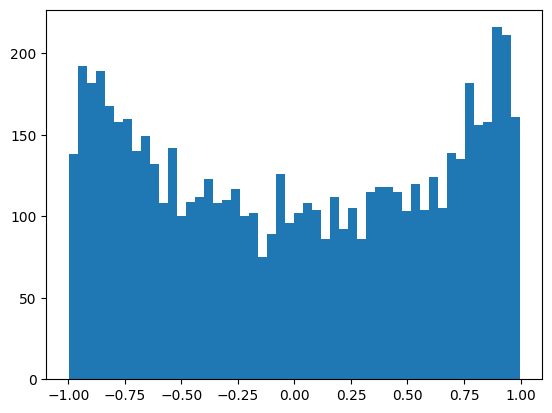

In [53]:
plt.hist(h.view(-1).tolist(),50)

(array([  1.,   0.,   2.,   1.,   2.,   1.,   0.,   5.,  11.,  14.,  25.,
         32.,  39.,  55.,  79.,  94., 133., 147., 184., 209., 234., 278.,
        298., 277., 341., 332., 335., 346., 328., 305., 335., 275., 251.,
        230., 234., 189., 161., 127., 139., 100.,  72.,  47.,  43.,  21.,
         26.,  16.,  14.,   8.,   1.,   3.]),
 array([-3.70772529, -3.57196502, -3.43620476, -3.30044449, -3.16468423,
        -3.02892396, -2.8931637 , -2.75740344, -2.62164317, -2.48588291,
        -2.35012264, -2.21436238, -2.07860211, -1.94284185, -1.80708158,
        -1.67132132, -1.53556106, -1.39980079, -1.26404053, -1.12828026,
        -0.99252   , -0.85675973, -0.72099947, -0.58523921, -0.44947894,
        -0.31371868, -0.17795841, -0.04219815,  0.09356212,  0.22932238,
         0.36508265,  0.50084291,  0.63660317,  0.77236344,  0.9081237 ,
         1.04388397,  1.17964423,  1.3154045 ,  1.45116476,  1.58692502,
         1.72268529,  1.85844555,  1.99420582,  2.12996608,  2.26572635,
 

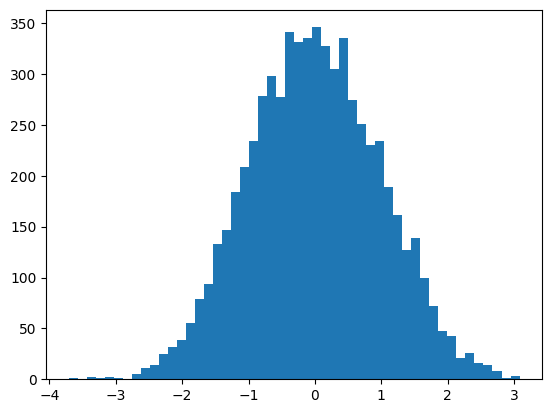

In [54]:
plt.hist(hpreact.view(-1).tolist(),50)

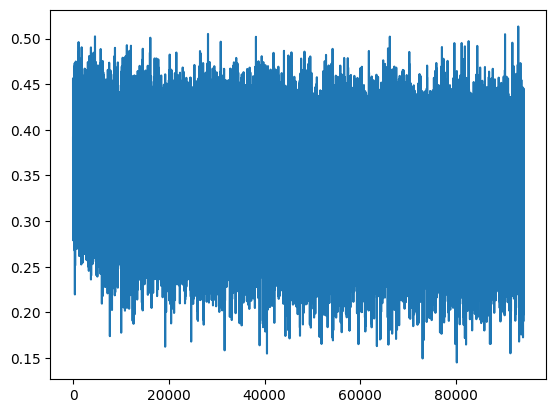

In [29]:
plt.plot(lossi)



In [45]:
# logits  = torch.tensor([-3.0,5.0,0.0,2.0])
logits  = torch.tensor([1.0,1.0,1.0,1.0])
logits = torch.randn(4)*10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([5.8541e-08, 6.5317e-01, 3.1290e-04, 3.4651e-01]), tensor(8.0696))

In [44]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.3118984699249268
val 3.312302589416504


In [57]:
# Summary

In [66]:
# Lets train a deep net more pro syle

from typing import Any


class Linear:

    def __init__(self, fan_in,fan_out,bais=True):
        self.weight = torch.randn((fan_in,fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bais else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = troch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update) no back prop
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__ (self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to nit variance
        self.out = self.gamma * xhat + self.beta
        # update bufferes
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
        


n_embd = 10 # the dim of the char embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g) # char embedding matrix
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]
with torch.no_grad():
    # last layer make less ocnfident
    layers[-1].weight *= 0.1
    # all other layers apply gain
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True




46497
46497


In [69]:
# rewrite after 1:27:00 of the video

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEB UG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break


RuntimeError: can't retain_grad on Tensor that has requires_grad=False